In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
cd "/content/drive/My Drive/Tensorflow Primer"

/content/drive/My Drive/Tensorflow Primer


## Importing requisite Libraries/Packages 

In [5]:
import os
import json
import glob
import shutil 
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimage 
import tensorflow as tf

In [7]:
# Check hardware accelerator
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [8]:
# Creating required folders 
if not os.path.isdir("models"):
  os.mkdir("models")

if not os.path.isdir("assets"):
  os.mkdir("assets")

if not os.path.isdir("checkpoints"):
  os.mkdir("checkpoints")

In [9]:
# Defining Base paths 
DATASET_DIR = "dataset"
MODELS_DIR = "models"
ASSETS_DIR = "assets"
CHECKPOINTS_DIR = "checkpoints"

## Simple EDA

In [10]:
print(os.listdir(DATASET_DIR))

['val', 'test', 'train']


## Directory structure for dataset
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;width:100%" >
<b>FOLDERS</b>
|__ <b>train</b>
|__ <b>val</b>
|__ <b>test</b>

<b>SUB-FOLDERS (CLASSES)</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

In [11]:
print(os.listdir(os.path.join(DATASET_DIR,'train')))

['sunflowers', 'roses', 'tulips', 'daisy', 'dandelion']


In [12]:
CLASSES = ['sunflowers', 'roses', 'tulips', 'daisy', 'dandelion']

In [13]:
DATASET_DISTRIBUTION = {}
for f in os.listdir(DATASET_DIR):
  images_count = 0
  for cls in CLASSES:
    cls_images = glob.glob(f"{DATASET_DIR}/{f}/{cls}/*.jpg")
    images_count += len(cls_images)
  print(f"{f} - {images_count} images")
  DATASET_DISTRIBUTION[f] = images_count

val - 551 images
test - 185 images
train - 2934 images


### Dataset distribution for train,test, and validation data

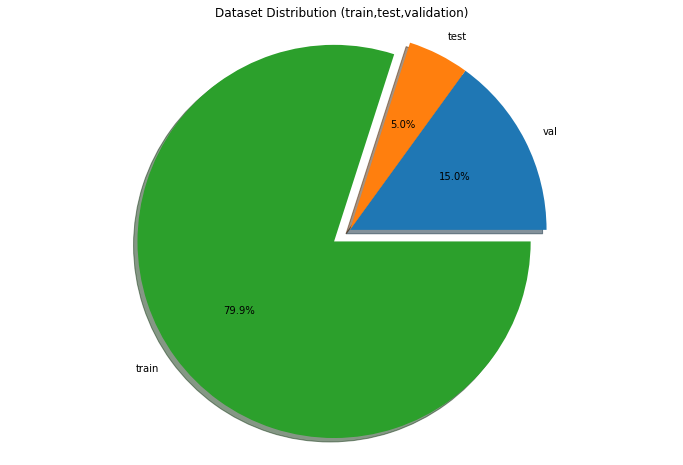

In [14]:
fig,ax = plt.subplots(figsize = (12,8))
ax.pie(
    DATASET_DISTRIBUTION.values(),
    explode = (0,0,0.1),
    labels = DATASET_DISTRIBUTION.keys(),
    autopct = "%1.1f%%",
    shadow = True
)
ax.axis('equal')
ax.set_title("Dataset Distribution (train,test,validation)")
plt.show()

### Class distribution in dataset

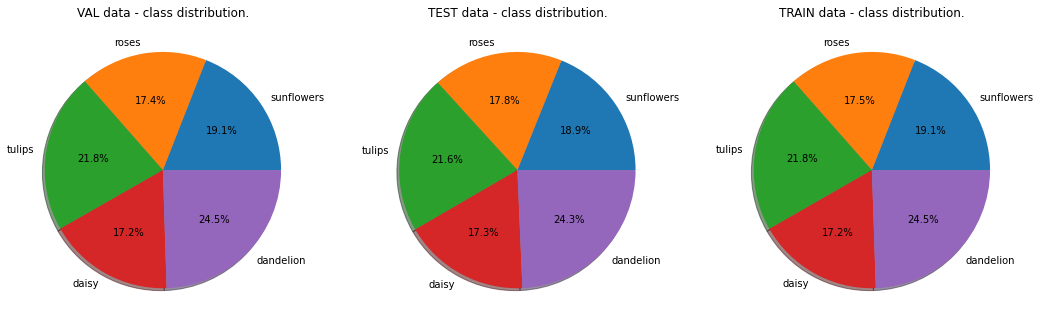

<Figure size 432x288 with 0 Axes>

In [15]:
fig,axes = plt.subplots(1,3,figsize=(18,8))
for idx,f in enumerate(os.listdir(DATASET_DIR)):
  ax = axes[idx]
  CLASS_DISTRIBUTION = {}
  for cls in CLASSES:
    CLASS_DISTRIBUTION[cls] = len(os.listdir(os.path.join(DATASET_DIR,f,cls)))
  ax.pie(
    CLASS_DISTRIBUTION.values(),
    labels = CLASS_DISTRIBUTION.keys(),
    autopct = "%1.1f%%",
    shadow = True
  )
  ax.set_title(f"{f.upper()} data - class distribution.")
plt.show()
plt.tight_layout()

## Displaying image samples

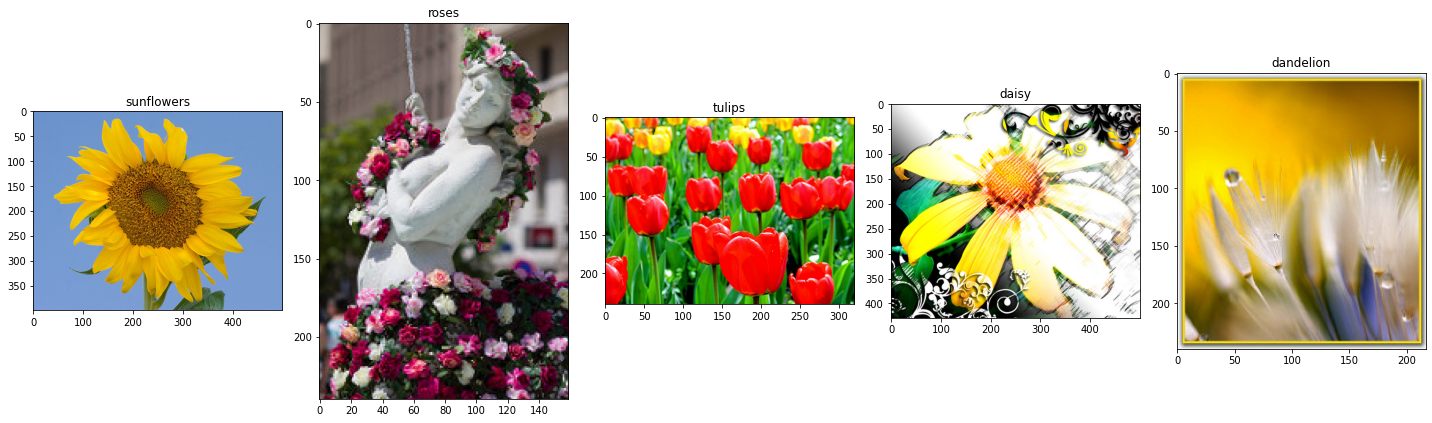

In [16]:
import random
fig,axes = plt.subplots(1,5, figsize=(20,8))
for idx,cls in enumerate(CLASSES):
  ax = axes[idx]
  images = glob.glob(f"{DATASET_DIR}/train/{cls}/*.jpg")
  sample = random.choice(images)
  img = mpimage.imread(sample)
  ax.imshow(img)
  ax.set_title(f"{cls}")
plt.tight_layout()
plt.show()

## Data loading and Augmentation 

We shall also augment our dataset using random transformations i.e. (zoom, contrast,rotation,shift) etc. This is due to the insufficient amount of data samples for training. This will consequently help our model generalize better and mitigate overfitting by training on diverse samples.

In [17]:
BATCH_SIZE = 32
IMAGE_DIM = (224,224)

In [18]:
# Helper function for plotting images 
def plotImages(images, n, figsize=(20,8)):
  fig,axes = plt.subplots(1,n, figsize=figsize)
  axes = axes.flatten()
  for img,ax in zip(images,axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [19]:
## Understanding image augmentation with a random image

simple_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
    tf.keras.layers.experimental.preprocessing.RandomRotation(20),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.15)
])

In [20]:
sunflower_image = mpimage.imread(random.choice(glob.glob(f"{DATASET_DIR}/train/sunflowers/*.jpg")))
# Add image to batch
sunflower_image = tf.expand_dims(sunflower_image, 0)

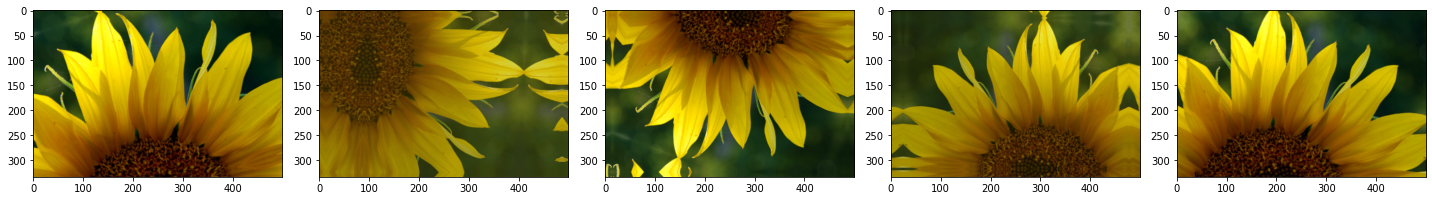

In [21]:
plotImages([simple_augmentation(sunflower_image)[0].numpy() for i in range(5)], 5)

### Using Image Data augmentation for easier loading and augmentation of train and validation data

Augmentation will only be applied to training samples, validation samples will only be normalized (rescaled by 255).

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Data Generator for Train data
image_generator_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = .15,
    height_shift_range = .15,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = .5,
    fill_mode = "nearest"
)

# Data Generator for Validation data
image_generator_val = ImageDataGenerator(
    rescale = 1./255
)

## Loading images from their corresponding directory

In [23]:
# Loading images for Train data 
train_data_gen = image_generator_train.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = os.path.join(DATASET_DIR,"train"),
    shuffle = True,
    target_size = IMAGE_DIM,
    class_mode = "categorical"
)

# Loading images for Validation data
val_data_gen = image_generator_val.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = os.path.join(DATASET_DIR,"val"),
    target_size = IMAGE_DIM,
    class_mode = "categorical",
    shuffle= False
)

Found 2934 images belonging to 5 classes.
Found 551 images belonging to 5 classes.


In [24]:
# Verifying loaded classes 
classes = train_data_gen.class_indices
print(classes)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [25]:
with open(os.path.join(ASSETS_DIR,"class_indices.json"), "w") as f:
  json.dump(classes, f)

## Building the model
The following model building techniques will be explored :- 

* Simple Convolutional Neural Network
* Leveraging Transfer learning to improve performance

In [26]:
# Importing required libraries
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### Building the model architecture for a simple convolutional network 
This convolutional network will contain 3 convolutional blocks. Each convolutional block consists of a `Conv2D` layer followed by a `MaxPooling2D` layer. The fully-connected block will consist of a `Flatten` layer, a `Dense` layer with 512 neurons and a final output `Dense` layer with 5 units (representing the number of classes). `Dropout` layers and `BatchNormalization` layers could also be added to mitigate overfitting.

In [27]:
# Building the model 
model = Sequential()

# Convolutional block
# First Convolution layer with 16 filters
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(*IMAGE_DIM, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolution layer with 32 filters
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Final Convolution layer with 64 filters 
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully-connected layers
model.add(Flatten())
# First Dropout layer (with 25%)
model.add(Dropout(0.25))
# First Dense layer with 512 neurons
model.add(Dense(512, activation='relu'))
# Final Dropout layer (with 25%)
model.add(Dropout(0.25))
#Final Dense layer with 5 units (representing the number of distinct classes)
model.add(Dense(5, activation='softmax'))

In [30]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)            

In [28]:
# Compiling the model 
INIT_LR = 3e-4
N_EPOCHS = 60

model.compile(
    optimizer = Adam(learning_rate = INIT_LR),
    loss = CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [29]:
# Model callbacks 
callbacks = [
      ModelCheckpoint(os.path.join(CHECKPOINTS_DIR,"flower_cnn_model_checkpoints.h5"), save_best_only=True, monitor='val_accuracy'),
      EarlyStopping(monitor='val_loss', patience=10, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1) 
]

In [33]:
# Training the model 

history = model.fit(
    train_data_gen,
    steps_per_epoch = int(np.ceil(train_data_gen.n/BATCH_SIZE)),
    epochs = N_EPOCHS,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(val_data_gen.n/BATCH_SIZE)),
    callbacks=callbacks
)

Epoch 1/60
92/92 [==============================] - 636s 7s/step - loss: 1.5636 - accuracy: 0.3582 - val_loss: 1.2410 - val_accuracy: 0.4991
Epoch 2/60
92/92 [==============================] - 42s 454ms/step - loss: 1.1830 - accuracy: 0.4951 - val_loss: 1.1627 - val_accuracy: 0.5481
Epoch 3/60
92/92 [==============================] - 42s 452ms/step - loss: 1.0963 - accuracy: 0.5570 - val_loss: 1.0082 - val_accuracy: 0.6152
Epoch 4/60
92/92 [==============================] - 42s 453ms/step - loss: 1.0372 - accuracy: 0.5957 - val_loss: 1.0622 - val_accuracy: 0.5880
Epoch 5/60
92/92 [==============================] - 41s 441ms/step - loss: 0.9963 - accuracy: 0.6025 - val_loss: 1.0202 - val_accuracy: 0.6062
Epoch 6/60
92/92 [==============================] - 40s 439ms/step - loss: 0.9578 - accuracy: 0.6390 - val_loss: 0.9873 - val_accuracy: 0.6044
Epoch 7/60
92/92 [==============================] - 40s 436ms/step - loss: 0.9373 - accuracy: 0.6297 - val_loss: 0.9411 - val_accuracy: 0.6334
E

## Plot learning curves

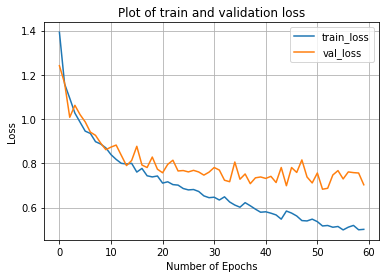

In [40]:
# Plot of loss for train and validation data
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(np.arange(N_EPOCHS), train_loss, label="train_loss")
plt.plot(np.arange(N_EPOCHS), val_loss, label="val_loss")
plt.legend(loc="best")
plt.title("Plot of train and validation loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(os.path.join(ASSETS_DIR, "loss_trend_cnn_model.jpg"))

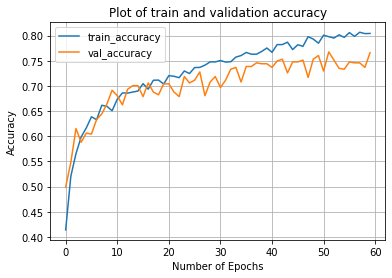

In [42]:
# Plot of accuracy for train and validation data
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(np.arange(N_EPOCHS), train_accuracy, label="train_accuracy")
plt.plot(np.arange(N_EPOCHS), val_accuracy, label="val_accuracy")
plt.legend(loc="best")
plt.title("Plot of train and validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig(os.path.join(ASSETS_DIR, "accuracy_trend_cnn_model.jpg"))

In [43]:
# Evaluate performance on the validation dataset 
val_accuracy, val_loss = model.evaluate(val_data_gen)

18/18 [==============================] - 2s 122ms/step - loss: 0.7033 - accuracy: 0.7659


In [44]:
print("Validation accuracy :-", val_accuracy)
print("Validation loss :-", val_loss)

Validation accuracy :- 0.7032687664031982
Validation loss :- 0.7658802270889282


In [80]:
# Confusion matrix and classification report 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(val_data_gen)
predictions = np.argmax(predictions, axis = 1)
print(predictions)
conf_matrix = confusion_matrix(val_data_gen.classes, predictions)

print(classification_report(
    val_data_gen.classes,
    predictions,
    target_names = list(classes.keys())
))

[0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 2 0 1 0 0 0 0 1 0 0 4 4 0 2 0 0 4 4 0 0 0 1 1 2 0 0 0 0 2 0 0
 0 2 0 0 1 0 0 0 0 0 0 4 1 0 2 0 0 0 0 0 0 1 1 3 1 1 1 1 3 2 1 3 1 3 1 4 1
 1 3 1 1 4 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 3 1 3 3 1 3 1 1 3 2 2 1 3 3 4
 3 1 1 3 1 1 1 0 0 1 1 0 1 1 1 1 0 1 4 1 1 1 0 0 3 1 1 1 1 1 1 3 1 1 1 1 2
 1 1 4 1 0 3 1 2 1 3 1 4 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 0 1 1 1
 1 1 1 1 1 3 0 1 4 0 2 2 4 2 1 0 2 4 2 2 0 2 2 4 2 2 2 4 4 2 2 4 0 2 2 2 2
 2 2 4 2 2 4 4 2 2 2 2 2 2 2 2 3 0 2 2 1 2 4 2 2 4 0 4 4 2 2 2 2 0 2 2 4 2
 4 2 0 4 2 2 4 4 3 4 2 2 2 2 2 2 4 2 2 4 4 4 3 0 2 2 2 2 4 2 3 3 3 3 4 3 3
 3 3 3 3 1 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 2 4 4 2 2 4 4 4 3 4
 4 2 4 4 4 2 3 4 2 3 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 3 4 4 2 2 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [81]:
# Plot confusion matrix helper function
# SOURCE :- https://www.kaggle.com/paultimothymooney/identify-dog-breed-from-image
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

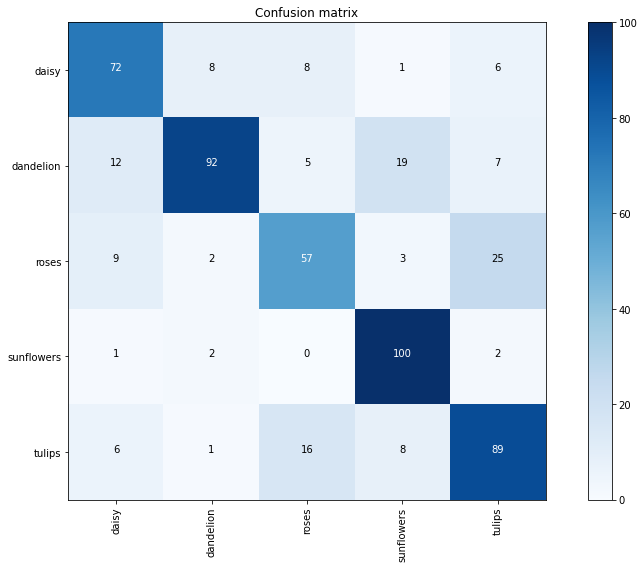

In [82]:
plot_confusion_matrix(conf_matrix, classes = list(classes.keys())) 

#### Serializing the model to disk

In [45]:
model.save(os.path.join(MODELS_DIR, "cnn_model_v1.h5"))

In [46]:
# Tensorflow SavedModel format 
tf.saved_model.save(model, os.path.join(MODELS_DIR, "cnn_tensorflow_savedmodel"))

INFO:tensorflow:Assets written to: models/cnn_tensorflow_savedmodel/assets


### Serialize model to yaml file and HDF5 weights

In [98]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open(os.path.join(MODELS_DIR,"flower_cnn_model_v1.yaml"),"w") as f:
  f.write(model_yaml)

In [99]:
# serialize weights to HDF5
model.save_weights(os.path.join(MODELS_DIR,"flower_cnn_model_weights_v1.h5"))

## Running predictions on a random test image

In [33]:
# Testing for a rose flower 
rose_img_path = random.choice(glob.glob(f"{DATASET_DIR}/test/roses/*.jpg"))
img = PIL.Image.open(rose_img_path)
img = img.resize(IMAGE_DIM, PIL.Image.ANTIALIAS)
img = tf.expand_dims(np.asarray(img)/255, 0)
predictions = model.predict(img)

In [34]:
class_map = {v:k for k,v in classes.items()}
print(predictions)
print(class_map[np.argmax(predictions)], f"{predictions.max()*100}%")

[[7.5670145e-02 3.2876766e-01 5.6329882e-01 5.4503867e-04 3.1718336e-02]]
roses 56.32988214492798%


In [35]:
model = tf.keras.models.load_model(os.path.join(MODELS_DIR, "cnn_model_v1.h5"))

In [87]:
# Function for returning predictions 
def predict(image_path : str, model):
  img = PIL.Image.open(image_path)
  resized_img = img.resize(IMAGE_DIM, PIL.Image.ANTIALIAS)
  img = tf.expand_dims(np.asarray(resized_img)/255, 0)
  predictions = model.predict(img)
  print("PREDICTIONS:- ", predictions)
  predicted_class = class_map[np.argmax(predictions)]
  print("CLASS:- ", predicted_class)
  return predicted_class,predictions.max()

In [88]:
predicted_class, confidence = predict(glob.glob(f"{DATASET_DIR}/test/sunflowers/*.jpg")[6], model)

PREDICTIONS:-  [[6.5658874e-06 5.4401980e-04 7.4938534e-06 9.9818534e-01 1.2566096e-03]]
CLASS:-  sunflowers


In [38]:
# Batch predictions
sunflower_preds = [predict(img)[0]=="sunflowers" for img in glob.glob(f"{DATASET_DIR}/test/sunflowers/*.jpg")]

PREDICTIONS:-  [[8.2346725e-01 4.9512913e-03 2.0572008e-04 1.7131680e-01 5.8993945e-05]]
CLASS:-  daisy
PREDICTIONS:-  [[2.3080802e-02 1.1818111e-03 2.3964012e-05 9.7566074e-01 5.2659296e-05]]
CLASS:-  sunflowers
PREDICTIONS:-  [[8.9639673e-10 8.7502711e-03 3.4578563e-06 9.9102050e-01 2.2575501e-04]]
CLASS:-  sunflowers
PREDICTIONS:-  [[2.3017648e-01 5.0587155e-02 5.0817110e-04 7.1843004e-01 2.9808437e-04]]
CLASS:-  sunflowers
PREDICTIONS:-  [[4.3918953e-06 2.0816376e-02 8.3740182e-05 9.7647458e-01 2.6209895e-03]]
CLASS:-  sunflowers
PREDICTIONS:-  [[1.9128563e-09 3.0716908e-06 7.0503059e-10 9.9999690e-01 4.7991826e-08]]
CLASS:-  sunflowers
PREDICTIONS:-  [[1.5335072e-05 8.5169618e-04 9.0899402e-06 9.9790895e-01 1.2150342e-03]]
CLASS:-  sunflowers
PREDICTIONS:-  [[5.7105009e-08 5.9053098e-04 1.5237466e-06 9.9923480e-01 1.7311788e-04]]
CLASS:-  sunflowers
PREDICTIONS:-  [[4.874155e-12 9.291757e-03 5.404094e-07 8.527837e-01 1.379240e-01]]
CLASS:-  sunflowers
PREDICTIONS:-  [[7.9498568e-1

In [39]:
print(sum(sunflower_preds)/len(sunflower_preds))

0.8857142857142857


## Leveraging Transfer learning

### 1. MobileNet

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [59]:
# Creating the Base model for the pre-trained MobileNetV2 model using imagenet weights

base_model = MobileNetV2(
    input_shape=(*IMAGE_DIM, 3),
    include_top=False,
    weights='imagenet'
)

In [60]:
print(base_model.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [61]:
# Freeze the convolutional base to prevent the weights from being updated during training 
base_model.trainable = False

In [63]:
mobilenetv2_model = tf.keras.Sequential([
   base_model,
   tf.keras.layers.GlobalAveragePooling2D(),
   Dropout(rate=0.2),
   Dense(5, activation='softmax')                                      
])

In [64]:
print(mobilenetv2_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [65]:
for idx,layer in enumerate(mobilenetv2_model.layers):
  print(idx, layer.name, layer.trainable)

0 mobilenetv2_1.00_224 False
1 global_average_pooling2d_2 True
2 dropout_4 True
3 dense_4 True


In [70]:
# Compile the model 
INIT_LR = 1e-4
N_EPOCHS = 20

mobilenetv2_model.compile(
    optimizer=Adam(learning_rate=INIT_LR),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [71]:
print(len(mobilenetv2_model.trainable_variables))

2


In [72]:
# Model callbacks 
callbacks = [
      ModelCheckpoint(os.path.join(CHECKPOINTS_DIR,"flower_mobilenetv2_model_checkpoints.h5"), save_best_only=True, monitor='val_accuracy'),
      EarlyStopping(monitor='val_loss', patience=10, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1) 
]

In [73]:
history = mobilenetv2_model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=N_EPOCHS,
    steps_per_epoch=int(np.ceil(train_data_gen.n/BATCH_SIZE)),
    validation_steps=int(np.ceil(val_data_gen.n/BATCH_SIZE)),
    callbacks=callbacks
)

Epoch 1/20
92/92 [==============================] - 43s 450ms/step - loss: 0.7070 - accuracy: 0.7330 - val_loss: 0.5813 - val_accuracy: 0.8058
Epoch 2/20
92/92 [==============================] - 41s 448ms/step - loss: 0.6230 - accuracy: 0.7655 - val_loss: 0.5598 - val_accuracy: 0.8185
Epoch 3/20
92/92 [==============================] - 42s 456ms/step - loss: 0.6084 - accuracy: 0.7736 - val_loss: 0.5437 - val_accuracy: 0.8330
Epoch 4/20
92/92 [==============================] - 41s 445ms/step - loss: 0.5768 - accuracy: 0.7829 - val_loss: 0.5260 - val_accuracy: 0.8367
Epoch 5/20
92/92 [==============================] - 41s 451ms/step - loss: 0.5897 - accuracy: 0.7923 - val_loss: 0.5142 - val_accuracy: 0.8385
Epoch 6/20
92/92 [==============================] - 41s 446ms/step - loss: 0.5932 - accuracy: 0.7855 - val_loss: 0.5019 - val_accuracy: 0.8439
Epoch 7/20
92/92 [==============================] - 41s 445ms/step - loss: 0.5443 - accuracy: 0.7977 - val_loss: 0.4948 - val_accuracy: 0.8475

##### We reached an accuracy of 86.03% on the validation dataset in 20 epochs. A significant improvement from the simple CNN model.

### Plot learning curves

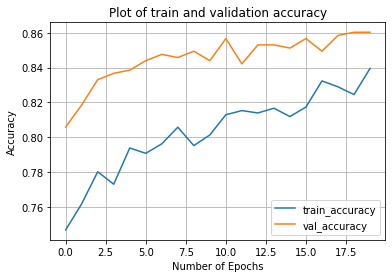

In [75]:
# Plot of accuracy for train and validation data
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(np.arange(N_EPOCHS), train_accuracy, label="train_accuracy")
plt.plot(np.arange(N_EPOCHS), val_accuracy, label="val_accuracy")
plt.legend(loc="best")
plt.title("Plot of train and validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig(os.path.join(ASSETS_DIR, "accuracy_trend_mobilenetv2_model.jpg"))

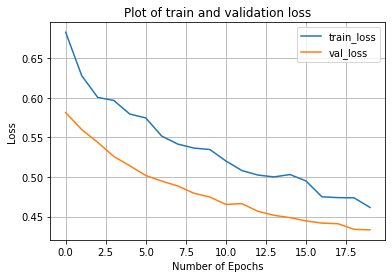

In [76]:
# Plot of loss for train and validation data
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(np.arange(N_EPOCHS), train_loss, label="train_loss")
plt.plot(np.arange(N_EPOCHS), val_loss, label="val_loss")
plt.legend(loc="best")
plt.title("Plot of train and validation loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(os.path.join(ASSETS_DIR, "loss_trend_mobilenetv2_model.jpg"))

In [77]:
# Evaluate performance on the validation dataset 
val_accuracy, val_loss = mobilenetv2_model.evaluate(val_data_gen)

18/18 [==============================] - 2s 131ms/step - loss: 0.4333 - accuracy: 0.8603


In [78]:
print("Validation accuracy :-", val_accuracy)
print("Validation loss :-", val_loss)

Validation accuracy :- 0.4332742393016815
Validation loss :- 0.8602541089057922


In [83]:
predictions = mobilenetv2_model.predict(val_data_gen)
predictions = np.argmax(predictions, axis = 1)
print(predictions)
conf_matrix = confusion_matrix(val_data_gen.classes, predictions)

print(classification_report(
    val_data_gen.classes,
    predictions,
    target_names = list(classes.keys())
))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 4 0 0 2 0 0 1 4 0 0 0 3 0 0 0 0 0 0 4 0 2
 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3 0 0 0 1 1 3 1 1 1 1 4 4 1 1 1 0 1 1 1
 1 3 1 1 4 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1
 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 1 2 2 2
 2 2 4 2 2 2 4 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 3 2 2 2 2 2 2 2 3 3 3 3 4 3 3
 3 3 4 3 1 3 3 1 1 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 4 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3
 3 3 3 3 3 4 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 4 4 4 4 2 0 2 4 4 4 4 4
 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 2 4 4
 4 4 4 4 4 1 2 4 4 4 4 4 

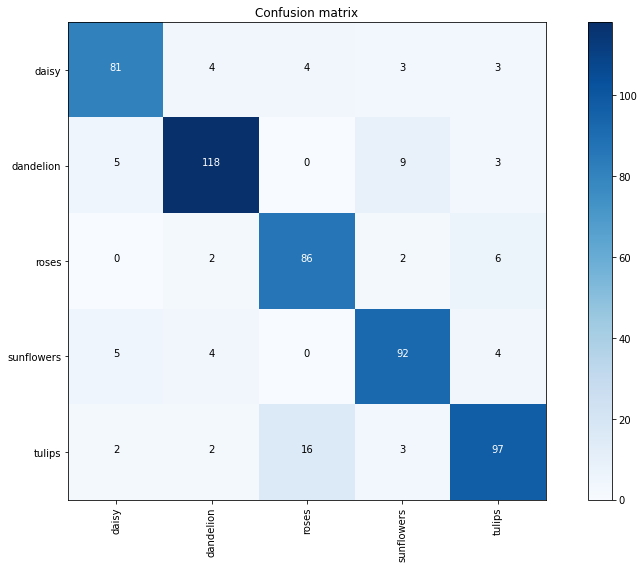

In [84]:
plot_confusion_matrix(conf_matrix, classes = list(classes.keys())) 

### Serializing the model to disk

In [96]:
mobilenetv2_model.save(os.path.join(MODELS_DIR, "flower_mobilenetv2_model_v1.h5"))

In [97]:
# Tensorflow SavedModel format 
tf.saved_model.save(mobilenetv2_model, os.path.join(MODELS_DIR, "flower_mobilenetv2_tensorflow_savedmodel"))

INFO:tensorflow:Assets written to: models/flower_mobilenetv2_tensorflow_savedmodel/assets


In [89]:
predicted_class, confidence = predict(glob.glob(f"{DATASET_DIR}/test/sunflowers/*.jpg")[6], mobilenetv2_model)

PREDICTIONS:-  [[0.00377729 0.03176622 0.06874263 0.89390725 0.00180661]]
CLASS:-  sunflowers


In [92]:
# Batch predictions
sunflower_preds = [predict(img,mobilenetv2_model)[0]=="sunflowers" for img in glob.glob(f"{DATASET_DIR}/test/sunflowers/*.jpg")]

PREDICTIONS:-  [[0.34574977 0.01006032 0.00896564 0.5992676  0.03595662]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.14512983 0.04041513 0.00376937 0.8006781  0.01000762]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.02934706 0.20809181 0.00220186 0.74841595 0.01194332]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.34655544 0.01495039 0.00411973 0.629447   0.00492754]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.31711227 0.02294269 0.00676689 0.6464563  0.00672191]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.18672152 0.03863327 0.00627314 0.7646215  0.00375067]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.00377729 0.03176622 0.06874263 0.89390725 0.00180661]]
CLASS:-  sunflowers
PREDICTIONS:-  [[7.1831517e-02 1.0661906e-02 5.1563239e-04 9.1681141e-01 1.7953615e-04]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.2394378  0.11528803 0.03793606 0.48006365 0.12727448]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.0019848  0.00424847 0.00123692 0.98921585 0.00331384]]
CLASS:-  sunflowers
PREDICTIONS:-  [[0.1826212  0.08726481 0.1072

In [93]:
print(sum(sunflower_preds)/len(sunflower_preds))

0.8857142857142857


In [94]:
# Batch predictions
rose_preds = [predict(img,mobilenetv2_model)[0]=="roses" for img in glob.glob(f"{DATASET_DIR}/test/roses/*.jpg")]
print(sum(rose_preds)/len(rose_preds))

PREDICTIONS:-  [[0.00650207 0.00336165 0.9760677  0.00953522 0.00453337]]
CLASS:-  roses
PREDICTIONS:-  [[3.4431749e-04 2.5546807e-04 9.6626163e-01 7.8772713e-04 3.2350790e-02]]
CLASS:-  roses
PREDICTIONS:-  [[4.8929208e-04 1.0001672e-03 8.9262444e-01 7.2381913e-04 1.0516237e-01]]
CLASS:-  roses
PREDICTIONS:-  [[5.6323097e-03 2.6744581e-04 9.6365190e-01 9.9517396e-03 2.0496646e-02]]
CLASS:-  roses
PREDICTIONS:-  [[0.7575929  0.0048767  0.02786533 0.04993813 0.159727  ]]
CLASS:-  daisy
PREDICTIONS:-  [[2.4692867e-05 3.6059377e-05 9.6861345e-01 7.6338802e-05 3.1249510e-02]]
CLASS:-  roses
PREDICTIONS:-  [[0.00733133 0.00378154 0.52650285 0.02944869 0.4329356 ]]
CLASS:-  roses
PREDICTIONS:-  [[6.1352685e-04 1.2288045e-03 9.1716385e-01 2.1626465e-03 7.8831211e-02]]
CLASS:-  roses
PREDICTIONS:-  [[0.00745848 0.00178299 0.89411676 0.00479964 0.09184207]]
CLASS:-  roses
PREDICTIONS:-  [[1.1830186e-04 9.6662465e-04 9.8427737e-01 1.2833918e-02 1.8039268e-03]]
CLASS:-  roses
PREDICTIONS:-  [[4.8

In [95]:
# Batch predictions
rose_preds = [predict(img,model)[0]=="roses" for img in glob.glob(f"{DATASET_DIR}/test/roses/*.jpg")]
print(sum(rose_preds)/len(rose_preds))

PREDICTIONS:-  [[0.07901759 0.7674018  0.08505041 0.00124109 0.06728904]]
CLASS:-  dandelion
PREDICTIONS:-  [[8.7182599e-09 3.7941331e-11 9.5907468e-01 7.2254508e-11 4.0925376e-02]]
CLASS:-  roses
PREDICTIONS:-  [[9.0993778e-04 5.4597618e-05 9.8573560e-01 1.9227141e-06 1.3298054e-02]]
CLASS:-  roses
PREDICTIONS:-  [[0.23890318 0.00147953 0.19323297 0.0067205  0.55966383]]
CLASS:-  tulips
PREDICTIONS:-  [[3.2577612e-02 2.7534991e-04 4.2303592e-01 6.6553177e-05 5.4404455e-01]]
CLASS:-  tulips
PREDICTIONS:-  [[1.1544834e-03 1.6881635e-05 9.7240078e-01 5.9762755e-07 2.6427267e-02]]
CLASS:-  roses
PREDICTIONS:-  [[1.6535245e-02 3.5065685e-07 7.9889441e-01 5.5309170e-06 1.8456446e-01]]
CLASS:-  roses
PREDICTIONS:-  [[0.09845152 0.06735215 0.5183728  0.07019325 0.24563026]]
CLASS:-  roses
PREDICTIONS:-  [[8.7963219e-04 3.8649872e-04 6.9115174e-01 1.4331310e-04 3.0743891e-01]]
CLASS:-  roses
PREDICTIONS:-  [[4.3207692e-05 4.2782613e-05 9.6028095e-01 2.9803869e-06 3.9630152e-02]]
CLASS:-  roses